# Image classification

## Imports

In [2]:
import os
import cv2
import math
import torch
import tarfile
import torchvision
import numpy as np
import pickle as pkl
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms


from PIL import Image
from skimage import io
from torch.hub import load_state_dict_from_url
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.transforms import RandomHorizontalFlip




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 

The model will be running on cuda:0 device



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining of functions

In [5]:
def getDataset(data_augmentation, set_type):
    if data_augmentation==True:
        transform = transforms.Compose([transforms.Resize((32,32)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(10),
                                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ])
    else:
        transform = transforms.Compose([transforms.Resize((32,32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5),
                                                             (0.5, 0.5, 0.5))
                                        ])
        
    if set_type in ['train', 'validation']:
        dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               download=True,
                                               transform=transform)
    elif set_type == 'test':
        dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=False,
                                               download=True,
                                               transform=transform)
    return dataset


def getTrainValidSampler(dataset, split_ratio=0.2):
    """ Used to allocate indices for train and validation samples """
    num_dataset = len(dataset)
    indices = list(range(num_dataset))
    split = int(np.floor(split_ratio * num_dataset))
    np.random.seed(1)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_s = SubsetRandomSampler(train_idx)
    valid_s = SubsetRandomSampler(valid_idx)
    return train_s, valid_s


**CNN Model:** Creating a new model class by adding a combination of convolutional and fully connected layers, ReLU, and max-pool.

In [7]:
class NetworkCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # fully connected
        x = torch.flatten(x, 1)        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


**Training Function**

In [8]:

def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)

def trainCnnModel(model, train_l, valid_loader, nepochs, learning_rate):
    losses_train_cnn = []
    val_loss = []
    cnfm_train = np.zeros((10,10),dtype=int)
    cnfm_val = np.zeros((10,10),dtype=int)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    labels_length = 10
    for epoch in range(nepochs):
        # train part
        labels_correct = list(0. for i in range(labels_length)) 
        labels_total = list(0. for i in range(labels_length)) 
        running_loss = 0.0
        for train_val in train_l:
            inputs, labels = train_val
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred_outputs = model(inputs)
            _, predicted = torch.max(pred_outputs, 1)
            loss = loss_fn(pred_outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            results = zip(labels, predicted)
            for i in results:
                cnfm_train[i[0].item(),i[1].item()] += 1
        losses_train_cnn.append(running_loss/len(train_loader))

        # validation part
        running_loss = 0.0
        loss_val = 0
        with torch.no_grad():
            model.eval()
            for val in valid_loader:
                inputs_val, labels_val = val
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                pred_outputs_val = model(inputs_val)
                _, predicted_val = torch.max(pred_outputs_val, 1)
                loss_val = loss_fn(pred_outputs_val, labels_val)
                running_loss += loss_val.item()
                results = zip(labels_val, predicted_val)
                for i in results:
                    cnfm_val[i[0].item(), i[1].item()] += 1
            val_loss.append(running_loss/len(valid_loader))
        print('# of epochs: {}, loss: {}, val: {} '.format(epoch, losses_train_cnn[epoch], val_loss[epoch]))
    return cnfm_train, cnfm_val, epoch, losses_train_cnn, val_loss

## Case without data augmentation

In [6]:
# Getting CIFAR10 datasets
train_set = getDataset(data_augmentation=False,set_type='train')
valid_set = getDataset(data_augmentation=False,set_type='validation')
test_set = getDataset(data_augmentation=False,set_type='test')
# Setting train validation samplers
train_sampler, valid_sampler = getTrainValidSampler(train_set)
batch_size = 4
# Loading CIFAR10 images
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_set,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=0)

# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
#                                          shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [10]:
# instantiating my Model class
cnn_model = NetworkCnn().to(device)
# running training function
cnfm_train, cnfm_val, epoch, train_losses, val_loss = trainCnnModel(cnn_model, train_loader, valid_loader, nepochs=12, learning_rate=0.001)

# of epochs: 0, loss: 1.351838381254673, val: 1.0955995423167944 
# of epochs: 1, loss: 1.0282934839395805, val: 0.9859986931100487 
# of epochs: 2, loss: 0.8881098248503986, val: 0.9550737148799934 
# of epochs: 3, loss: 0.7805404467216693, val: 0.9683981587940361 
# of epochs: 4, loss: 0.6814992997695386, val: 0.9911867737604305 
# of epochs: 5, loss: 0.5931240229906456, val: 1.062123484294943 
# of epochs: 6, loss: 0.5103314638932942, val: 1.0956360287704912 
# of epochs: 7, loss: 0.44069033612610203, val: 1.2782625853822676 
# of epochs: 8, loss: 0.3801497224301314, val: 1.4197005401051426 
# of epochs: 9, loss: 0.33957264036569595, val: 1.5193783243581942 
# of epochs: 10, loss: 0.2890486261068111, val: 1.7644306751950463 
# of epochs: 11, loss: 0.2713761223794382, val: 1.855911989764231 


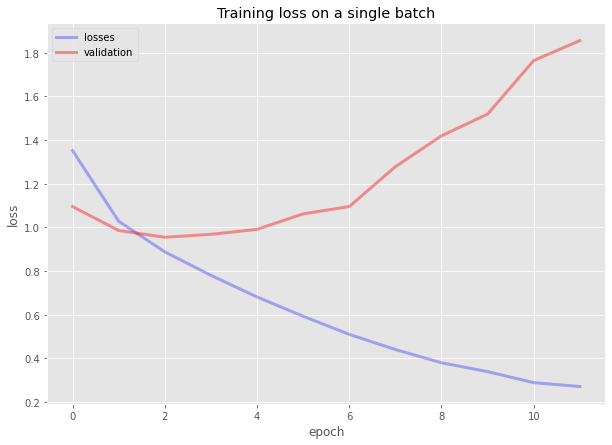

In [12]:
# graph
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,7))
plt.plot(train_losses, label = 'losses', lw=3, alpha=0.3, color='blue')
plt.plot(val_loss, label = 'validation', lw=3, alpha=0.4, color='red')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss on a single batch')
plt.show()

#### We can observe that after the 3rd epoch the model has started overfitting - as the validation loss drifts.

In [14]:
# Case with data augmentation

# Getting CIFAR10 datasets
train_set = getDataset(data_augmentation=True,set_type='train')
valid_set = getDataset(data_augmentation=False,set_type='validation')
test_set = getDataset(data_augmentation=False,set_type='test')
# Setting train validation samplers
train_sampler, valid_sampler = getTrainValidSampler(train_set)
batch_size = 4
# Loading CIFAR10 images
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_set,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
# instantiating my Model class
cnn_model = NetworkCnn().to(device)
# running training function
cnfm_train, cnfm_val, epoch, train_losses, val_loss = trainCnnModel(cnn_model, train_loader, valid_loader, nepochs=40, learning_rate=0.001)

# of epochs: 0, loss: 1.7624143834739923, val: 1.517146343421936 
# of epochs: 1, loss: 1.5717489187121392, val: 1.4312281906068325 
# of epochs: 2, loss: 1.461412964375317, val: 1.3083151160299777 
# of epochs: 3, loss: 1.3497970938287676, val: 1.2386549694597722 
# of epochs: 4, loss: 1.2862598313048481, val: 1.1996264947250486 
# of epochs: 5, loss: 1.2435043809518218, val: 1.123767618021369 
# of epochs: 6, loss: 1.2047942142467947, val: 1.0979306928172707 
# of epochs: 7, loss: 1.1841525145443157, val: 1.1117619450554252 
# of epochs: 8, loss: 1.1569272288225592, val: 1.0617942658089101 
# of epochs: 9, loss: 1.1287473127629608, val: 1.0426561416316777 
# of epochs: 10, loss: 1.1173001156371087, val: 1.0373233464308083 
# of epochs: 11, loss: 1.09890208025123, val: 1.0595500454408118 
# of epochs: 12, loss: 1.0904735715329648, val: 0.9980946033069864 
# of epochs: 13, loss: 1.0777715779690071, val: 0.9818189375527203 
# of epochs: 14, loss: 1.0634217556510122, val: 0.9774399609202

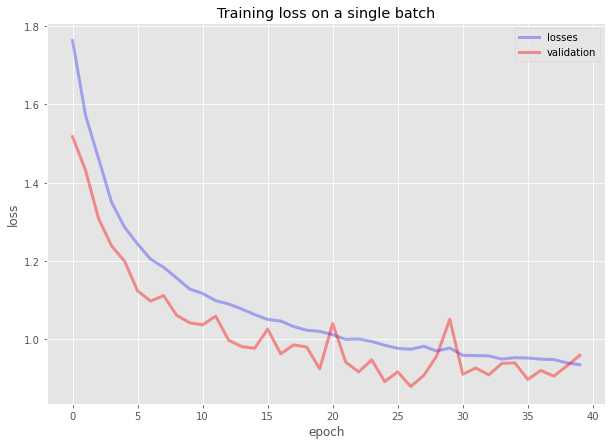

In [18]:
# graph
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,7))
plt.plot(train_losses, label = 'losses', lw=3, alpha=0.3, color='blue')
plt.plot(val_loss, label = 'validation', lw=3, alpha=0.4, color='red')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss on a single batch')
plt.show()

#### After the data augmentation the model has run 40 epochs without signs of overfitting.

### Confusion matrices

In [19]:
# show per-class recall and precision cnfm_train, cnfm_val
print(f"Training Accuracy: {accuracy(cnfm_train) :.1%}")
r = recalls(cnfm_train)
p = precisions(cnfm_train)
for i in range(10):
    print(f"Class {i+1} : Precision {p[i] :.1%}  Recall {r[i] :.1%}") 

Training Accuracy: 62.0%
Class 1 : Precision 65.1%  Recall 65.8%
Class 2 : Precision 73.0%  Recall 75.2%
Class 3 : Precision 53.6%  Recall 50.0%
Class 4 : Precision 43.7%  Recall 42.8%
Class 5 : Precision 56.5%  Recall 56.6%
Class 6 : Precision 53.3%  Recall 49.8%
Class 7 : Precision 65.0%  Recall 71.0%
Class 8 : Precision 69.0%  Recall 66.1%
Class 9 : Precision 69.8%  Recall 73.6%
Class 10 : Precision 68.1%  Recall 68.6%


In [20]:
print(f"Validation Accuracy: {accuracy(cnfm_val) :.1%}")
r = recalls(cnfm_val)
p = precisions(cnfm_val)
for i in range(10):
    print(f"Class {i+1} : Precision {p[i] :.1%}  Recall {r[i] :.1%}") 

Validation Accuracy: 65.3%
Class 1 : Precision 68.8%  Recall 69.0%
Class 2 : Precision 76.8%  Recall 77.4%
Class 3 : Precision 56.8%  Recall 52.9%
Class 4 : Precision 47.7%  Recall 43.3%
Class 5 : Precision 61.5%  Recall 59.5%
Class 6 : Precision 52.8%  Recall 56.9%
Class 7 : Precision 70.2%  Recall 70.0%
Class 8 : Precision 68.8%  Recall 71.6%
Class 9 : Precision 75.7%  Recall 77.6%
Class 10 : Precision 72.3%  Recall 75.4%


## Conclusion
* Data augmentation has significantly changed our model in terms of overfitting. 
* After 40 epoches this model delivered a decent overall performance.
* Maybe by running more epochs or using more layers a better performace could be achieved.